In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.datasets import fashion_mnist
from keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda
from keras.optimizers import Adam
import numpy as np
from PIL import Image
import tensorflow as tf

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, y_train, x_test, y_test = x_train[5000::], y_train[5000::], x_test[1000::], y_test[1000::]

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=-1))
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=-1))
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def resize_images(images):
    return tf.image.resize(images, size=(75, 75))

x_train = Lambda(resize_images)(x_train)
x_test = Lambda(resize_images)(x_test)

base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=x_train.shape[1:])
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, verbose=1)
model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/15
860/860 [==============================] - 245s 155ms/step - loss: 0.4016 - accuracy: 0.8547 - val_loss: 0.3220 - val_accuracy: 0.8868
Epoch 2/15
860/860 [==============================] - 127s 148ms/step - loss: 0.3151 - accuracy: 0.8905 - val_loss: 1.2338 - val_accuracy: 0.7999
Epoch 3/15
860/860 [==============================] - 126s 147ms/step - loss: 0.3293 - accuracy: 0.8881 - val_loss: 0.3933 - val_accuracy: 0.8576
Epoch 4/15
860/860 [==============================] - 127s 147ms/step - loss: 0.2877 - accuracy: 0.9014 - val_loss: 0.4409 - val_accuracy: 0.8732
Epoch 5/15
860/860 [==============================] - 137s 160ms/step - loss: 0.2559 - accuracy: 0.9107 - val_loss: 0.2495 - val_accuracy: 0.9082
Epoch 6/15
860/860 [==============================] - 126s 147ms/step - loss: 0.2848 - accuracy: 0.9050 - val_loss: 0.5666 - val_accuracy: 0.8810
Epoch 7/15
860/860 [==============================] - 126s 147ms/step - loss: 0.2042 - accuracy: 0.9251 - val_loss: 0.2305 -

In [ ]:
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

282/282 [==============================] - 13s 28ms/step
Test loss: 0.3348768651485443
Test accuracy: 0.8768888711929321


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [ ]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4200, 4233, 4233, 4171, 4189, 4161, 4245, 4229, 4196, 4143]
test groups: [1800, 1767, 1767, 1829, 1811, 1839, 1755, 1771, 1804, 1857]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

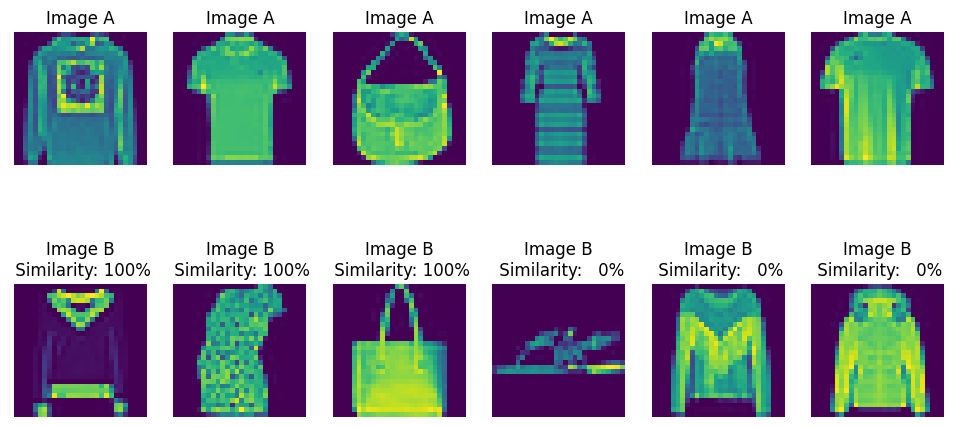

In [ ]:
import matplotlib.pyplot as plt

pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [ ]:
from tensorflow.keras import layers

img_in = layers.Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')

x = layers.Conv2D(64, 3, padding="same")(img_in)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x1 = layers.concatenate([img_in, x], name = 'merge_features')

x = layers.Conv2D(64, 3, padding="same")(x1)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x2 = layers.concatenate([x1, x])

x = layers.Conv2D(64, 3, padding="same")(x2)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x3 = layers.concatenate([x2, x])

x = layers.Conv2D(64, 3, padding="same")(x3)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x4 = layers.concatenate([x3, x])

x = layers.Conv2D(256, 3, padding="same")(x4)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax")(x)

feature_model = keras.Model(inputs = [img_in], outputs = outputs, name = 'DenseNet')
feature_model.summary()

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 FeatureNet_ImageInput (InputLa  [(None, 28, 28, 1)]  0          []                               
 yer)                                                                                             
                                                                                                  
 conv2d_238 (Conv2D)            (None, 28, 28, 64)   640         ['FeatureNet_ImageInput[0][0]']  
                                                                                                  
 batch_normalization_233 (Batch  (None, 28, 28, 64)  256         ['conv2d_238[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [ ]:
img_a_in = layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = layers.Dense(16, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(4, activation = 'linear')(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = keras.Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 DenseNet (Functional)          (None, 10)           860298      ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['DenseNet[0][0]',

In [ ]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

1/1 [==============================] - 1s 611ms/step


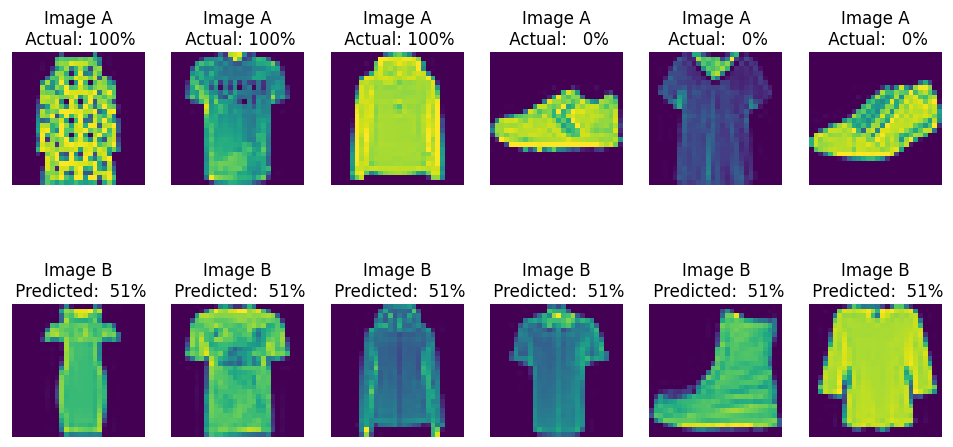

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
        
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                                    steps_per_epoch = 500,
                                    validation_data=([valid_a, valid_b], valid_sim),
                                    epochs = 10,
                                    verbose = True)

Epoch 1/10
500/500 [==============================] - 51s 80ms/step - loss: 0.5534 - mae: 0.3952 - val_loss: 0.5754 - val_mae: 0.4030
Epoch 2/10
500/500 [==============================] - 40s 81ms/step - loss: 0.4202 - mae: 0.2889 - val_loss: 0.5377 - val_mae: 0.3241
Epoch 3/10
500/500 [==============================] - 41s 81ms/step - loss: 0.3785 - mae: 0.2516 - val_loss: 0.6083 - val_mae: 0.3189
Epoch 4/10
500/500 [==============================] - 42s 83ms/step - loss: 0.3733 - mae: 0.2434 - val_loss: 1.2639 - val_mae: 0.4395
Epoch 5/10
500/500 [==============================] - 41s 81ms/step - loss: 0.3559 - mae: 0.2304 - val_loss: 0.4008 - val_mae: 0.2385
Epoch 6/10
500/500 [==============================] - 41s 81ms/step - loss: 0.3450 - mae: 0.2212 - val_loss: 0.3369 - val_mae: 0.2111
Epoch 7/10
500/500 [==============================] - 41s 81ms/step - loss: 0.3407 - mae: 0.2180 - val_loss: 0.3416 - val_mae: 0.2120
Epoch 8/10
500/500 [==============================] - 41s 81ms

1/1 [==============================] - 0s 31ms/step


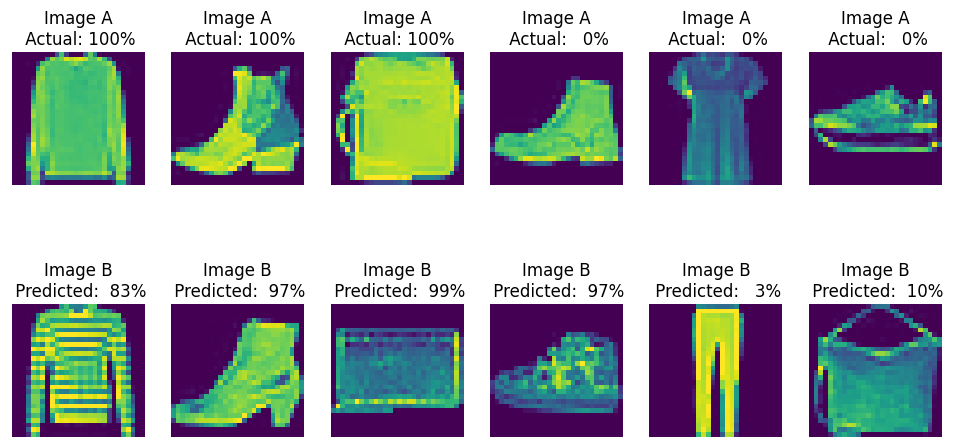

In [ ]:
_ = show_model_output()

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose= True, batch_size = 128)

141/141 [==============================] - 11s 77ms/step


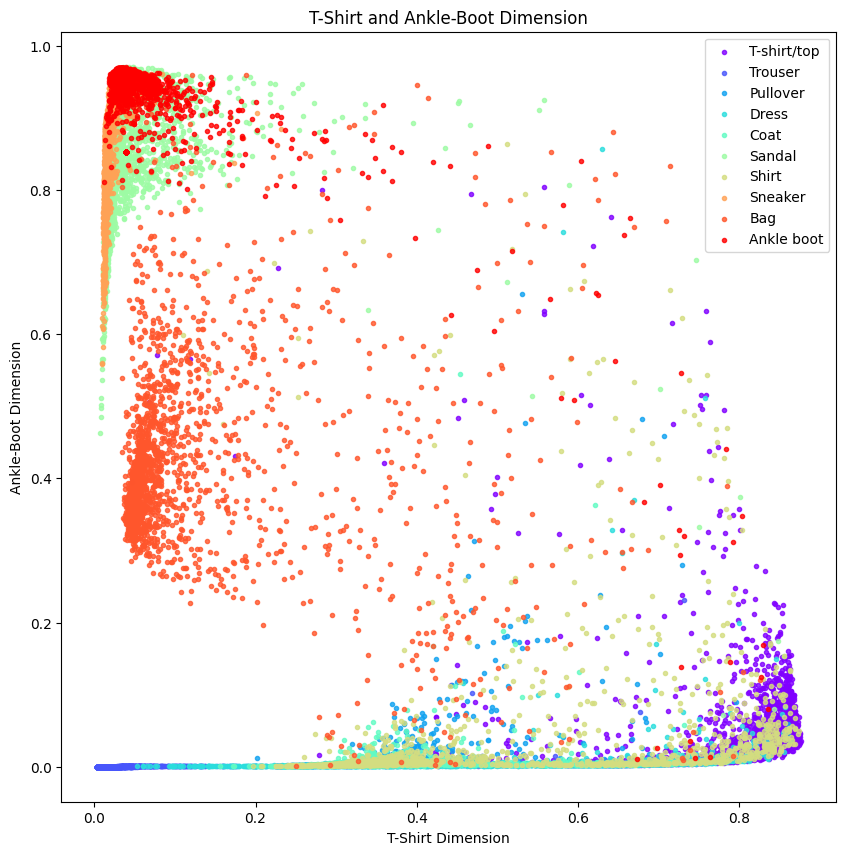

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [ ]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 6s 39ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=1000,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.026s...
[t-SNE] Computed neighbors for 18000 samples in 0.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

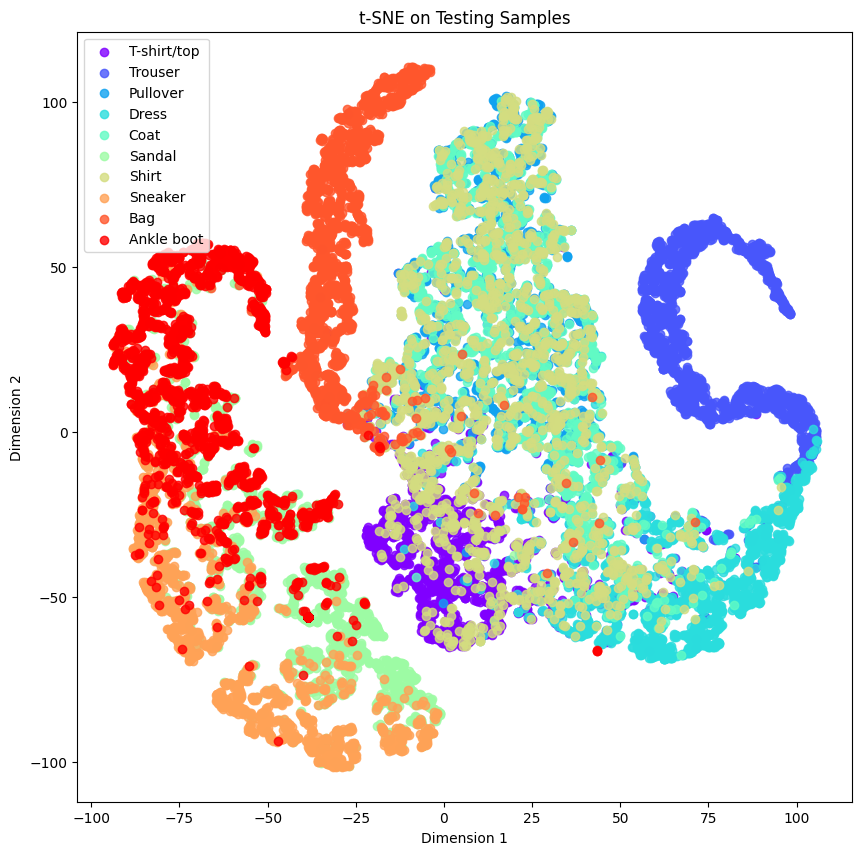

In [ ]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)